In [1]:
import torch, os
import pandas as pd
# plot, for each column compute mean and std error
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch.nn import Module

In [2]:
elu_feature_map = lambda x: torch.nn.functional.elu(x) + 1

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [10]:
seq_len = [2**i for i in range(4, 16)] # 32768 at most
head_dims = [32, 64, 128, 256]
num_heads = [2, 4, 8, 16]

def get_func(func_name):
    if func_name == "standard":
        return standard_linear_attn
    elif func_name == 'feature_map':
        return feature_map_linear_attn
    elif func_name == 'feature_map_norm':
        return original_linear_attn
    elif func_name == 'original':
        return original_implement_linear_attn
    else:
        raise ValueError(f"Unknown function name: {func_name}")
    
def get_csv(func_name, head_dim, num_head, mode):
    if func_name in ['standard', 'feature_map']:
        return f'../results/linear_attn/{func_name}_head_dim_{head_dim}_num_head_{num_head}_{mode}_usage.csv'
    else:
        return f'../results/{func_name}_head_dim_{head_dim}_num_head_{num_head}_{mode}_usage.csv'
    
@torch.no_grad()
def benchmark(
    func_name, 
    n_repeat=5,
    batch_size = 10, 
    seed = 0,
    self_attn = True,
    overwrite = False,
):
    torch.manual_seed(seed)
    
    func = get_func(func_name)

    for head_dim in head_dims:
        for num_head in num_heads:
            time_usage, memory_usage = {}, {}
            for sl in seq_len:
                time_csv = get_csv(func_name, head_dim, num_head, "time")
                memory_csv = get_csv(func_name, head_dim, num_head, "memory")
                
                if os.path.exists(time_csv) and os.path.exists(memory_csv) and not overwrite:
                    print(f"Skip head dim {head_dim}, {num_head} heads, length-{sl}.")
                    continue
                
                time_usage[sl], memory_usage[sl] = [], []

                # record cuda time
                for i in range(n_repeat):
                    torch.cuda.empty_cache()
                    torch.cuda.reset_peak_memory_stats(device='cuda')
                    memory_before = torch.cuda.memory_allocated(device="cuda")
                    torch.manual_seed(seed * i)
                    if self_attn:
                        q = torch.randn(batch_size, num_head, sl, head_dim, device = "cuda")
                        k = q
                        v = q
                    else:
                        q = torch.randn(batch_size, num_head, 100, head_dim, device = "cuda")
                        k = torch.randn(batch_size, num_head, sl, head_dim, device = "cuda")
                        v = torch.randn(batch_size, num_head, sl, head_dim, device = "cuda")
                        
                    if i == 0: 
                        # warmup
                        func(q, k, v)
                    else:
                        start = torch.cuda.Event(enable_timing=True)
                        end = torch.cuda.Event(enable_timing=True)
                        start.record()
                        func(q, k, v)
                        end.record()
                        torch.cuda.synchronize()
                        memory_after = torch.cuda.max_memory_allocated(device="cuda")

                        time_usage[sl].append(start.elapsed_time(end))
                        memory_usage[sl].append(memory_after - memory_before)
                      
                    del q, k, v
                    

            time_usage_df, memory_usage_df, = pd.DataFrame(time_usage), pd.DataFrame(memory_usage)
            time_usage_df.to_csv(time_csv)
            memory_usage_df.to_csv(memory_csv)

In [11]:
def standard_linear_attn(q, k, v): 
    """
    q: query tensor of shape (batch_size, num_head, seq_len_q, head_dim_qk) bhld
    k: key tensor of shape (batch_size, num_head, seq_len_kv, head_dim_qk) bhnd
    v: value tensor of shape (batch_size, num_head, seq_len_kv, head_dim_v) bhnm
    memory usage for a self-attention: (batch_size*num_head*sl*head_dim*2 + batch_size*num_head*head_dim*head_dim)*4
    """
    scale = q.size(-1) ** -0.5
    
    # kv = torch.matmul(k.transpose(2, 3), v)
    # o = torch.matmul(q, kv) * scale
    
    kv = torch.einsum("bhnd,bhnm->bhdm", k, v)
    # attention output o: (batch_size, seq_len_q, num_head, head_dim_v)
    o = torch.einsum("bhld,bhdm->bhlm", q, kv) * scale
    
    # o = torch.einsum('bhnd,bhnm,bhld->bhlm', k, v, q) * scale

    # When you call contiguous(), it actually makes a copy of the tensor such that 
    # the order of its elements in memory is the same as if it had been created 
    # from scratch with the same data.
    # If o is not contiguous, it creates a new contiguous tensor, temporarily doubling the memory of o.
    return o.contiguous()

In [12]:
def feature_map_linear_attn(q, k, v): 
    """
    q: query tensor of shape (batch_size, num_head, seq_len_q, head_dim_qk) bhld
    k: key tensor of shape (batch_size, num_head, seq_len_kv, head_dim_qk) bhnd
    v: value tensor of shape (batch_size, num_head, seq_len_kv, head_dim_v) bhnm
    memory usage for a self-attention: (batch_size*num_head*sl*head_dim*2 + batch_size*num_head*head_dim*head_dim)*4
    """
    scale = q.size(-1) ** -0.5
    
    
    # kv = torch.matmul(k.transpose(2, 3), v)
    # o = torch.matmul(q, kv) * scale
    
    kv = torch.einsum("bhnd,bhnm->bhdm", elu_feature_map(k), v)
    # attention output o: (batch_size, seq_len_q, num_head, head_dim_v)
    o = torch.einsum("bhld,bhdm->bhlm", elu_feature_map(q), kv) * scale
    
    # o = torch.einsum('bhnd,bhnm,bhld->bhlm', k, v, q) * scale

    # When you call contiguous(), it actually makes a copy of the tensor such that 
    # the order of its elements in memory is the same as if it had been created 
    # from scratch with the same data.
    # If o is not contiguous, it creates a new contiguous tensor, temporarily doubling the memory of o.
    return o.contiguous()

In [13]:
@torch.jit.script
def normalize_output(q, k, o):
    k = k.transpose(-2, -1)
    # cumulative sum 
    # >>> a = torch.randint(1, 20, (10,))
    # >>> a
    # tensor([13,  7,  3, 10, 13,  3, 15, 10,  9, 10])
    # >>> torch.cumsum(a, dim=0)
    # tensor([13, 20, 23, 33, 46, 49, 64, 74, 83, 93])
    k = k.cumsum(-1)
    k = k.transpose(-2, -1)
    z = (q * k).sum(-1, keepdim=True)
    return o / (z + 1e-5)

def original_linear_attn(q, k, v):
    scale = q.size(-1) ** -0.5
    
    
    # kv = torch.matmul(k.transpose(2, 3), v)
    # o = torch.matmul(q, kv) * scale
    
    kv = torch.einsum("bhnd,bhnm->bhdm", elu_feature_map(k), v)
    # attention output o: (batch_size, seq_len_q, num_head, head_dim_v)
    o = torch.einsum("bhld,bhdm->bhlm", elu_feature_map(q), kv) * scale
    
    # o = torch.einsum('bhnd,bhnm,bhld->bhlm', k, v, q) * scale

    # When you call contiguous(), it actually makes a copy of the tensor such that 
    # the order of its elements in memory is the same as if it had been created 
    # from scratch with the same data.
    # If o is not contiguous, it creates a new contiguous tensor, temporarily doubling the memory of o.
    o = normalize_output(q, k, o)
    return o.contiguous()

In [14]:
def original_implement_linear_attn(q, k, v, eps = 1e-6):
    # check feature map
    kv = torch.einsum("bhnd,bhnm->bhdm", elu_feature_map(k), v)
    # compute the normalizer
    z = 1/(torch.einsum("bhld,bhd->bhl", q, k.sum(dim=2)) + eps)
    o = torch.einsum("bhld,bhdm,bhl->bhlm", q, kv, z)
    return o.contiguous()
    

In [15]:
benchmark('standard', overwrite=True)

In [26]:
benchmark('feature_map', overwrite=True)

In [16]:
benchmark('feature_map_norm', overwrite=True)

In [17]:
benchmark('original', overwrite=True)

# Plot 

In [37]:
legend_converter = {
    "standard": "standard linear attention",
    "feature_map": "linear attention with feature map",
    'fa2': 'flash attention II',
    'feature_map_norm': 'linear attention with feature map and normalization',
    'original': 'original implementation of linear attention'
}

color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
marker_list = ['o', '^', 'v', '<', '>', 'p', 'h', 'H', 'd', 'P', 'X']
marker_sizes = [13, 11, 9, 7, 5]

plot_order = ['standard', 'feature_map', 'fa2', 'feature_map_norm', 'original']

In [38]:
results = {}

for mode in ['memory', 'time']:
    results[mode] = {}
    for func_name in plot_order:
        results[mode][func_name] = {}
        for head_dim in head_dims:
            results[mode][func_name][head_dim] = {}
            for num_head in num_heads:
                try:
                    results[mode][func_name][head_dim][num_head] = pd.read_csv(get_csv(func_name, head_dim, num_head, mode), index_col = 0)
                except FileNotFoundError:
                    results[mode][func_name][head_dim][num_head] = None

In [42]:
def plot(mode):
    fig, axs = plt.subplots(
        len(head_dims), 
        len(num_heads), 
        figsize=(6*len(num_heads), 6*len(head_dims)),
        sharey=True,
    )
    fig.subplots_adjust(wspace=0.1, hspace = 0.5) 
    for f, func_name in enumerate(plot_order):
        for i in range(len(head_dims)):
            axs[i][0].set_ylabel(mode, fontsize=30)
            for j in range(len(num_heads)):
                df = results[mode][func_name][head_dims[i]][num_heads[j]]
                if df is None:
                    continue
                mean = df.mean()
                std = df.std()
                xticks = [int(x) for x in mean.index]
                axs[i][j].errorbar(
                    xticks, 
                    mean, 
                    yerr = std, 
                    label = legend_converter[func_name], 
                    color = color_list[f], 
                    marker = marker_list[f],
                    markersize = marker_sizes[f],
                )
                
                axs[i][j].grid(True, which="major", ls="-", alpha=0.2)
                # set title for each subplot
                axs[i][j].set_title(f"head_dim={head_dims[i]}\n num_head={num_heads[j]}", fontsize = 30)
                
    axs[-1][-1].legend(loc='upper center', bbox_to_anchor= (-1, 6.4), ncol=3,fontsize=30)
    plt.show()


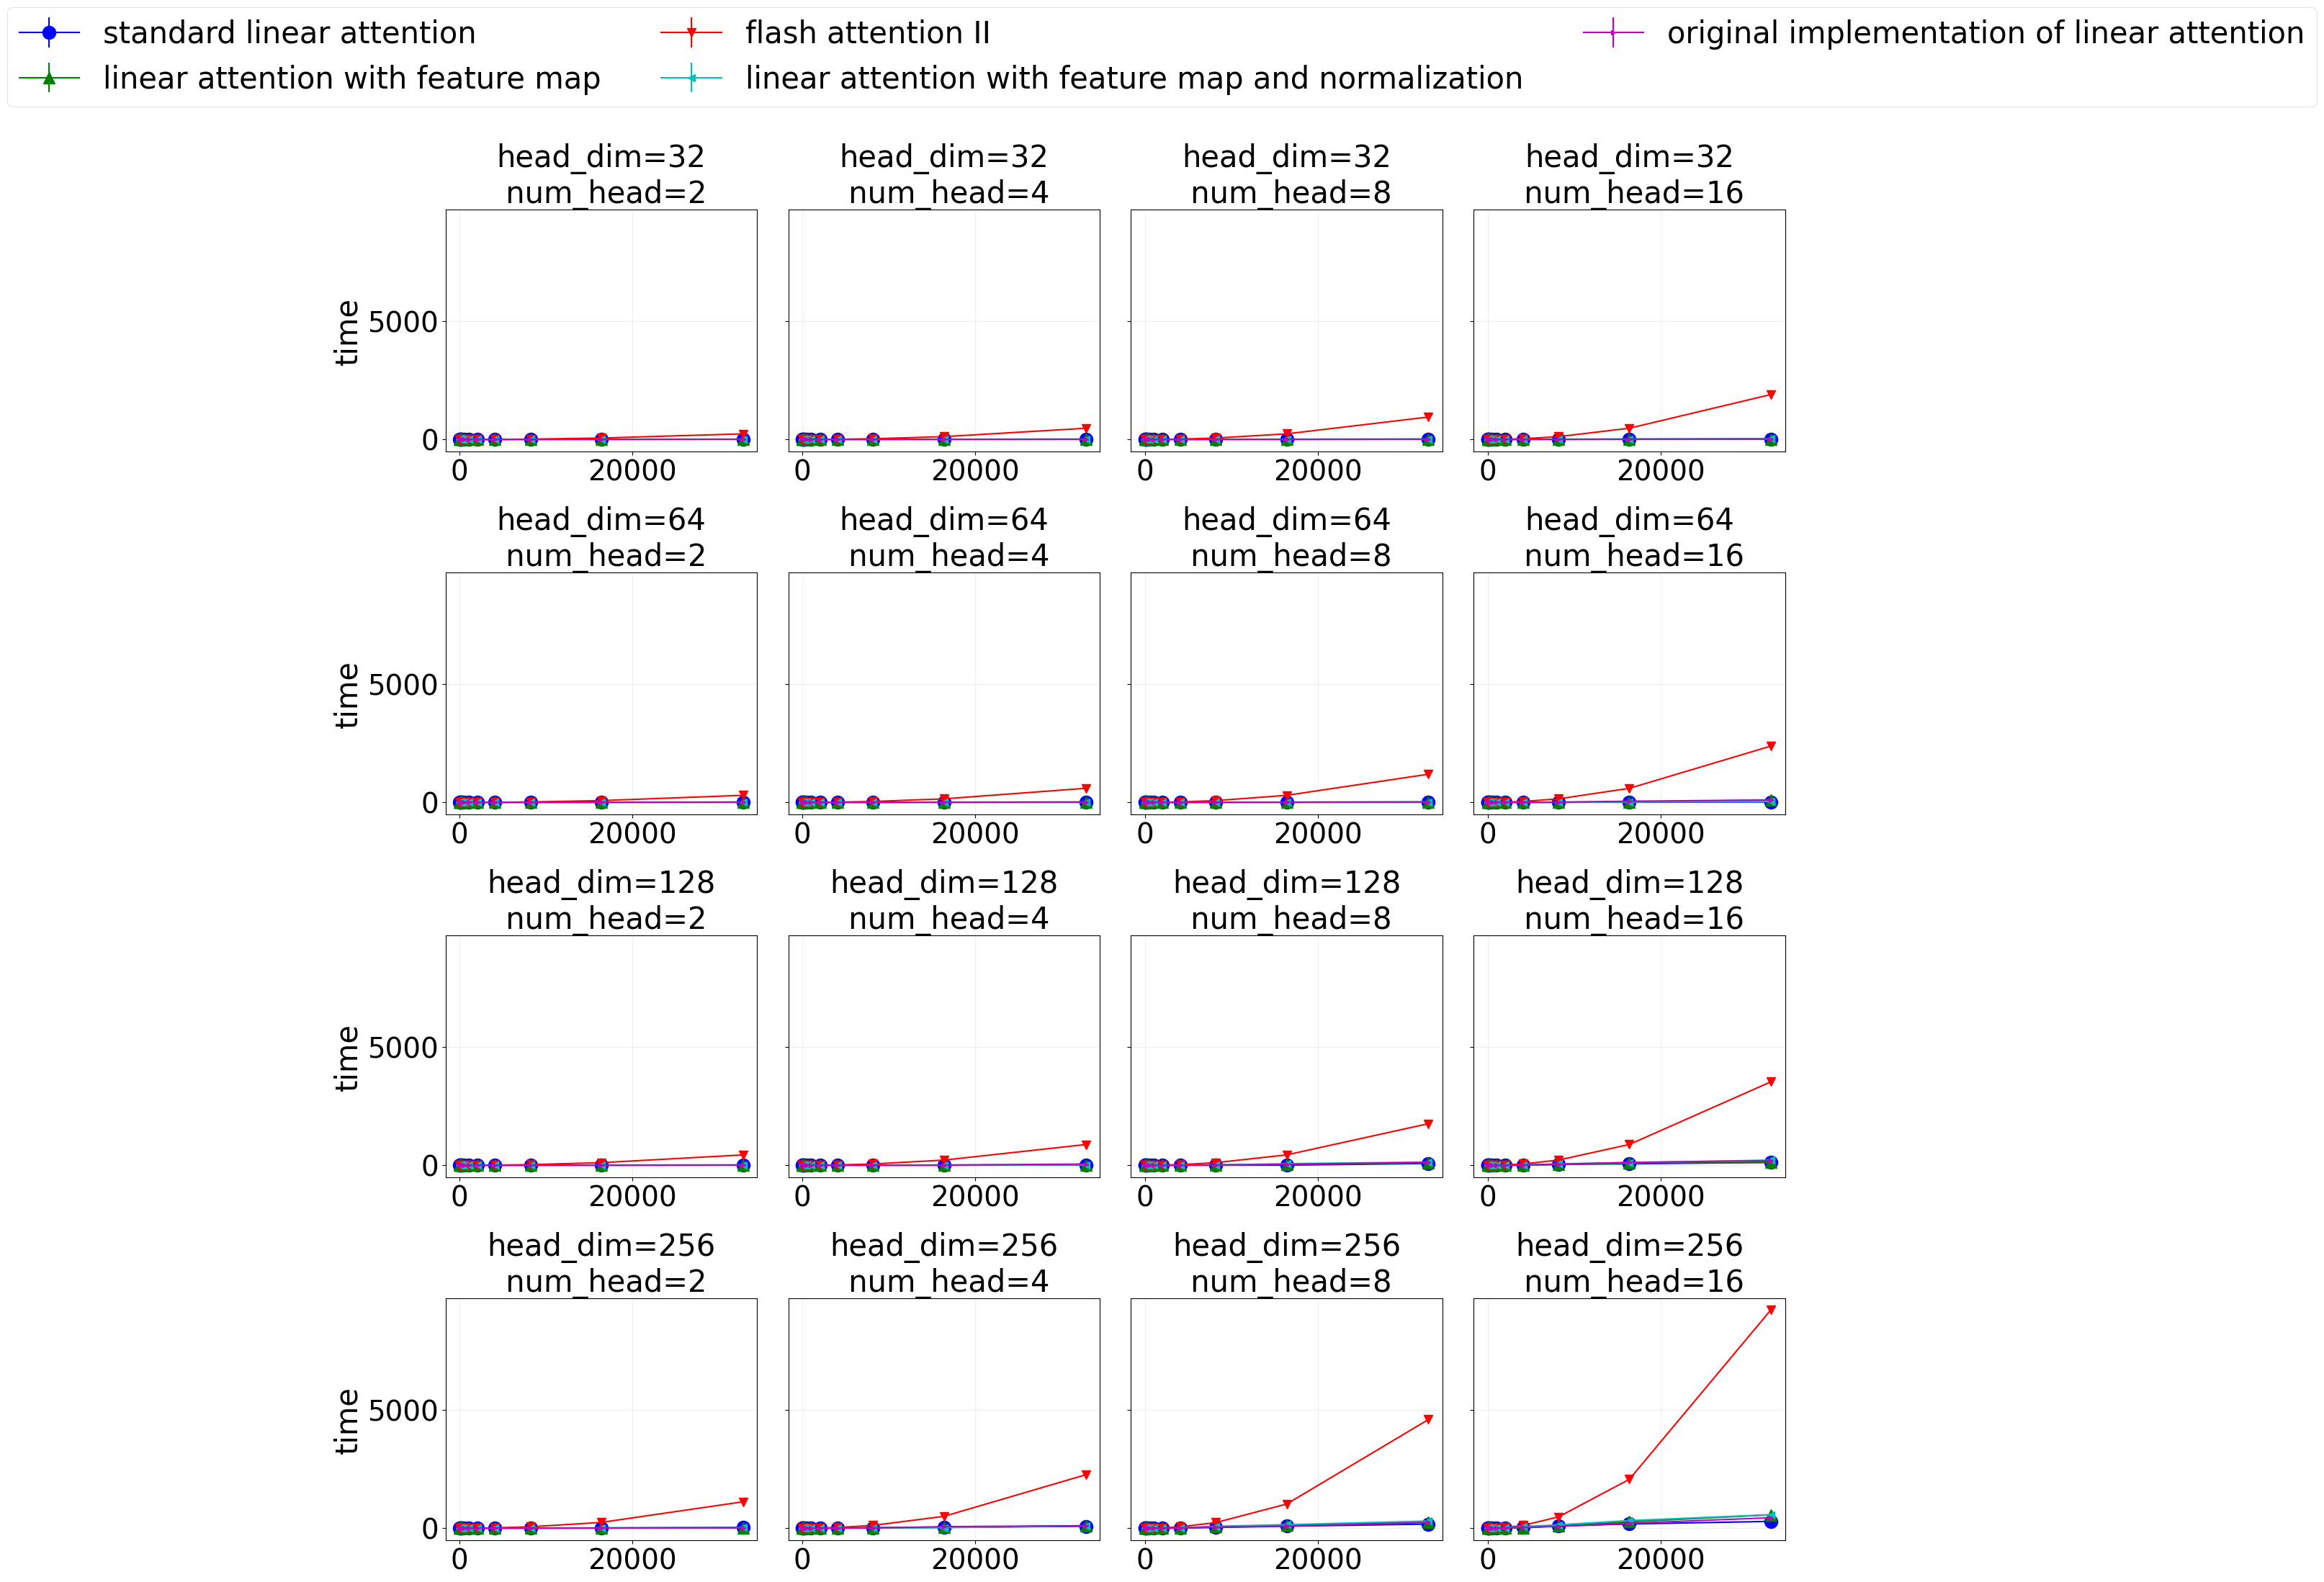

In [43]:
plot('time')

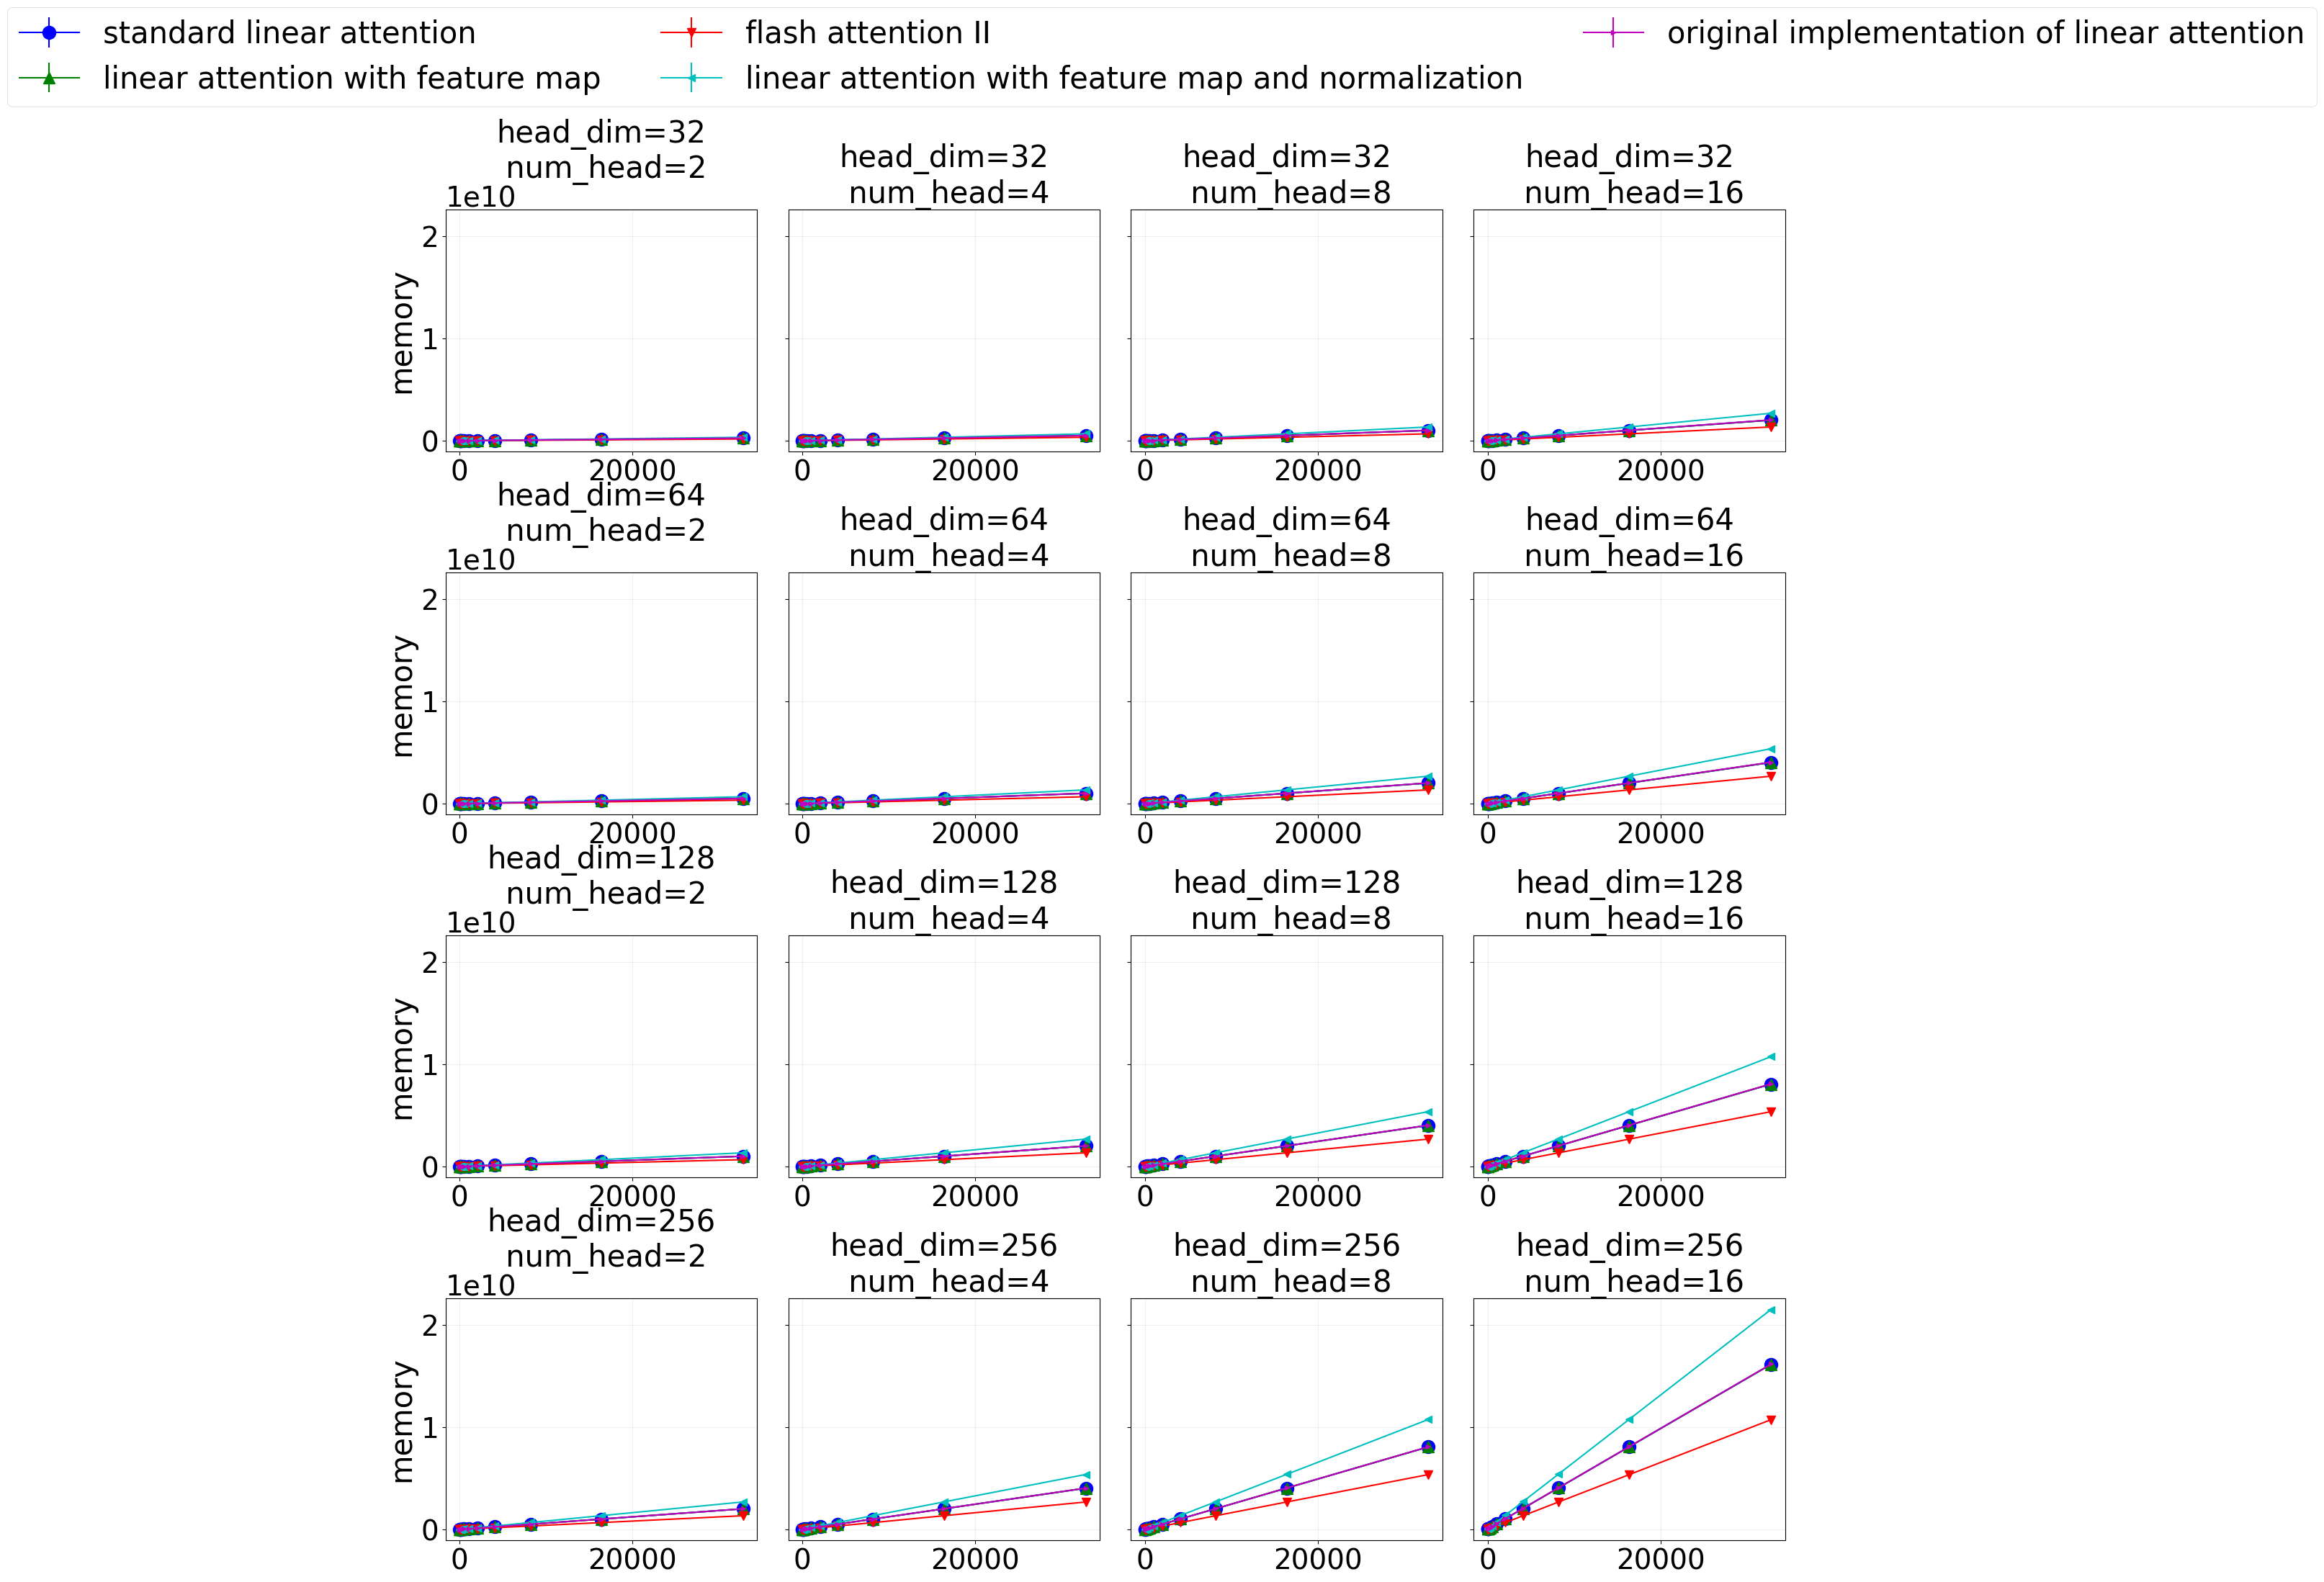

In [44]:
plot('memory')